# Lecture 18: Logistic regression, binary classifier

In last few lectures we have learned the linear regression, where we explore the possibility of using a linear function to represent the relation of the data ($x$ values, or training data `X_train`) and a label ($y$ values `y_train`), so that we can predict the label $y$ (`y_pred`) using testing data `X_test`.

Today, we will learn how to predict a discrete label such as 
* predicting whether a grid of pixel intensities represents a "0" digit or a "1" digit;
* predicting whether tomorrow will have rain based on previous days' data.

This is a classification problem. Logistic regression is a simple classification algorithm for learning to make such decisions for a binary label.

Reference: adapted from the MATLAB tutorial in [Stanford Deep Learning tutorial](http://deeplearning.stanford.edu/tutorial/).

# MNIST
Now let us look at the famous [MNIST dataset of handwritten digits](http://yann.lecun.com/exdb/mnist/), we should download the zip file on Canvas or the [csv files from Kaggle](https://www.kaggle.com/oddrationale/mnist-in-csv).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_train = np.loadtxt('mnist_train.csv', delimiter=',')

In [3]:
data_train.shape

(60000, 785)

In [4]:
# each row is a training sample + label
# pixel intensity ranges from 0 to 255
data_train[0:3,380:400]
data_train[:3,0]

array([5., 0., 4.])

## What does the data look like?
The first column `data_train[:,0]` is the label, and the rest 784 columns `data_train[:,1:]` represent the image. Let us try to visualize the first 20 rows of the training data, with their labels.

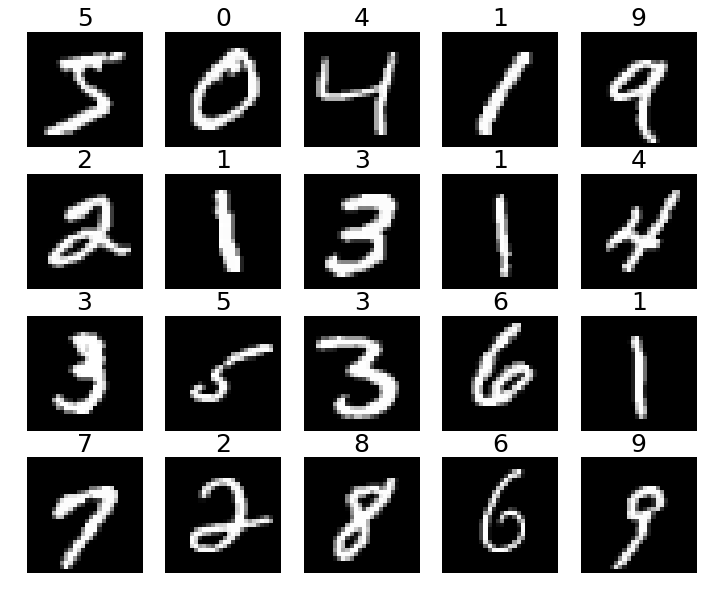

In [5]:
X = data_train[:,1:]
y = data_train[:,0]

fig, axes = plt.subplots(4,5, figsize=(12, 10))
axes = axes.reshape(-1)

for i in range(20):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(X[i,:].reshape(28,28), cmap = 'gray')
    axes[i].set_title(str(int(y[i])), color= 'black', fontsize=25)
plt.show()

## Extraction of the training data
Now let us extract 0's and 1's from the data set.

In [6]:
# 784 = 28x28
X.shape

(60000, 784)

In [7]:
y.shape

(60000,)

In [8]:
(y == 1)[:10]

array([False, False, False,  True, False, False,  True, False,  True,
       False])

In [12]:
# extract the indices of the training samples with label 0 or 1
zero_and_one = (y == 1) + (y == 0)
zero_and_one_indx = np.nonzero(zero_and_one)
zero_and_one_indx = zero_and_one_indx[0]

In [13]:
X_train = X[zero_and_one_indx,:]
y_train = y[zero_and_one_indx]

In [14]:
np.nonzero(y == 1)[0][:10]

array([ 3,  6,  8, 14, 23, 24, 40, 59, 67, 70], dtype=int64)

In [15]:
np.nonzero(zero_and_one)[0].shape

(12665,)

## Double check if it is really 0 and 1

In [16]:
X_train[1,:].shape

(784,)

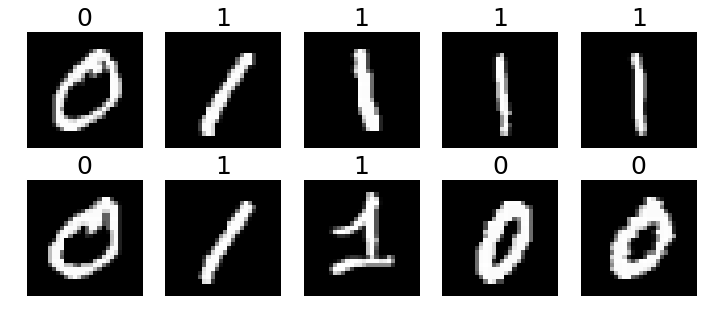

In [17]:
fig, axes = plt.subplots(2,5, figsize=(12, 5))
axes = axes.reshape(-1)
for i in range(10):
    axes[i].axis('off') # hide the axes ticks
    axes[i].imshow(X_train[i,:].reshape(28,28), cmap = 'gray')
    axes[i].set_title(str(int(y_train[i])), color= 'black', fontsize=25)
plt.show()

# Logistic regression (reading)
In linear regression we tried to predict the value of $y^{(i)}$ for the $i$-th sample $\mathbf{x}^{(i)}$ using a linear function $y=h(\mathbf{x}) = \mathbf{w}^{\top} [1, \; \mathbf{x}] $. This is clearly not a great solution for predicting wine quality score (which we can classify as "favorable" and "unfavorable"). 

For binary-valued labels, e.g., $y^{(i)} \in \{0,1\}$, we can use **logistic regression** to try to predict the probability that a given example belongs to the "1" class versus the probability that it belongs to the "0" class. Specifically, we will try to learn a function of the form:

$$
\begin{aligned}
h(\mathbf{x}) = P(y=1|\mathbf{x}) & = \frac{1}{1 + \exp(-\mathbf{w}^\top \mathbf{x})}
=: \sigma(\mathbf{w}^\top \mathbf{x})  ,\\[5pt]
1 - h(\mathbf{x}) = P(y=0|\mathbf{x}) &= 1 - P(y=1|\mathbf{x}) ,
\end{aligned}
$$
or more compactly, because $y = 0$ or $1$:
$$
P(y|\mathbf{x}) = h(\mathbf{x})^y \big(1 - h(\mathbf{x}) \big)^{1-y}
$$

----

## Sigmoid function
The function $\sigma(z) = 1/\big(1+\exp(−z)\big)$ is often called the "sigmoid" or "logistic" function, or "logistic/sigmoid" activation function in machine learning. It is an S-shaped function that "squashes" the value of $\mathbf{w}^\top \mathbf{x}$ into the range $[0,1]$ so that we may interpret $h(\mathbf{x})$ as a probability. Our goal is to search for a value of $\mathbf{w}$ so that:
> The probability $P(y=1|\mathbf{x})=h(\mathbf{x})$ is large when $x$ belongs to the "1" class, small when $x$ belongs to the "0" class (so that $P(y=0|\mathbf{x})=1- h(\mathbf{x})$ is large). 

----

## Maximum likelihood
For a set of training examples with binary labels $\{(\mathbf{x}^{(i)},y^{(i)}):i=1,\dots,N\}$ the following likelihood estimator measures how well a given $h(\mathbf{x})$ does this: assuming our training samples are independently Bernoulli distributed, we want to maximize the following quantity
$$
{\begin{aligned}L(\mathbf{w} | \mathbf{x})&=P(\mathbf{y}\; | \; \mathbf{X};\mathbf{w} )\\
&=\prod _{i=1}^N P\left(y^{(i)}\mid \mathbf{x}^{(i)};\mathbf{w}\right)\\
&=\prod_{i=1}^N h\big(\mathbf{x}^{(i)} \big)^{y_{i}} \Big(1-h\big(\mathbf{x}^{(i)}\big) \Big)^{(1-y_{i})}
\end{aligned}}.
$$
This function is highly nonlinear on the weights $\mathbf{w}$ so we take the log and define our loss function to be minimized as follows:
$$
\ell (\mathbf{w}) = - \sum_{i=1}^N 
\Bigl\{y^{(i)} \ln\big( h(\mathbf{x}^{(i)}) \big) 
+ (1 - y^{(i)}) \ln\big( 1 - h(\mathbf{x}^{(i)}) \big) \Bigr\}.
\tag{$\star$}
$$
Note that only one of the two terms in the summation is non-zero for each training sample (depending on whether the label $y^{(i)}$ is 0 or 1). When $y^{(i)}=1$ minimizing the loss function means we need to make $h(x^{(i)})$ large, and when $y^{(i)}= 0$ we want to make $1- h(x^{(i)})$ large as explained above. 

----

## Training and cross-validation
After the loss function $\ell (\mathbf{w})$ is set up, the training data is used by the gradient descent to minimize $\ell (\mathbf{w})$ to find the best choice of weights $\mathbf{w}$. Even though the cost function $(\star)$ looks quite complicated, due to the following special property of the Sigmoid function 
$$
\frac{d}{dz} \big(\sigma(z)\big)
 = \frac{d}{dz} \left(\frac{1}{1+\exp(−z)}\right) = \sigma(z)\cdot \big(1-\sigma(z)\big).
$$
Therefore recalling $h(\mathbf{x}) =  \sigma(\mathbf{w}^\top \mathbf{x})$
$$
\begin{aligned}
\frac{\partial \ell (\mathbf{w})}{\partial w_k} & = 
- \sum_{i=1}^N 
\Bigg\{y^{(i)}  \frac{1}{h(\mathbf{x}^{(i)})} \frac{\partial}{\partial w_k} \sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}  \big)
+ (1 - y^{(i)}) \frac{1}{1-h(\mathbf{x}^{(i)})} \frac{\partial}{\partial w_k}\Big(1-  \sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}\big)  \Big) \Bigg\}
\\
& = - \sum_{i=1}^N 
\Bigg\{y^{(i)}  \frac{1}{h(\mathbf{x}^{(i)})} 
\sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}\big) 
\cdot \big(1-\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})\big) 
\frac{\partial}{\partial w_k} \sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}  \big)
\\
& \qquad \qquad - (1 - y^{(i)}) \frac{1}{1-h(\mathbf{x}^{(i)})} 
\sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}\big) 
\cdot \big(1-\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})\big) 
\frac{\partial}{\partial w_k}\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}\big)  \Bigg\}
\\
& = - \sum_{i=1}^N 
\Bigg\{y^{(i)} \cdot \big(1-\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})\big) 
\frac{\partial}{\partial w_k} \sigma\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}  \big)
- (1 - y^{(i)}) \cdot
\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)}) 
\frac{\partial}{\partial w_k}\big(\mathbf{w}^{\top} \mathbf{x}^{(i)}\big)  \Bigg\}
\\
& =\sum_{i=1}^N  \big(\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})  - y^{(i)} \big) x^{(i)}_k.
\end{aligned}
$$
The final expression is pretty simple, basically the derivative of the Logistic loss function w.r.t. the $k$-th weight $w_k$ is the sum of the residuals $\big(\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})  - y^{(i)} \big) $ multiply with the $k$-th component in the $i$-th training data $\mathbf{x}^{(i)}$.

Therefore the gradient for all the weights $\mathbf{w}$ is then:
$$
\nabla_{\mathbf{w}} \big( \ell (\mathbf{w}) \big) = \sum_{i=1}^N  \big(\sigma(\mathbf{w}^{\top} \mathbf{x}^{(i)})  - y^{(i)} \big) \mathbf{x}^{(i)} 
=\sum_{i=1}^N \big( h(\mathbf{x}^{(i)})  - y^{(i)} \big) \mathbf{x}^{(i)}  . \tag{$\dagger$}
$$

## Exercise:
Prove for the Sigmoid function $\sigma(z)$: 
$\displaystyle\frac{d}{dz} \big(\sigma(z)\big) = \sigma(z)\cdot \big(1-\sigma(z)\big).
$

## Gradient descent
Now let us run the gradient descent based on $(\dagger)$, with code adapted from Lecture 16.

In [18]:
# global training data
X = X_train
y = y_train
N = len(y)
w  = np.zeros(np.shape(X)[1]) 
# zero initial guess, np.shape(X)[1] = 784, which is no. of pixels
# and we want it to be small

In [19]:
# model h(X; w) = sigma(-Xw)
# w: weights
# x: training data
# x has shape 12665 (no. of samples) row by 784 (no. of features)
# w has shape 784
def h(w,X):
    z = np.matmul(X,w)
    return 1.0 / (1.0 + np.exp(-z))

# loss function, modulo by N (size of training data), a vectorized implementation without for loop
def loss(w,X,y):
    loss_components = np.log(h(w,X)) * y + (1.0 - y)* np.log(1 - h(w,X))
    # above is a dimension (12665,) array
    return -np.mean(loss_components) # same with loss_components.sum()/N

def gradient_loss(w,x,y):
    gradient_for_all_training_data = (h(w,X) - y).reshape(-1,1)*X
    # we should return a (784,) array, which is averaging all 12655 training data
    return np.mean(gradient_for_all_training_data, axis=0)

In [20]:
# np.reshape(-1,1) trick is often used in vectorized programming in python
np.arange(10).reshape(-1,1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [21]:
# let us check the loss function and its gradient, if they are too big...we are in trouble
# and we can add some gradient checking
loss(w,X,y)

0.6931471805599452

In [22]:
np.linalg.norm(gradient_loss(w,X,y))

462.5264508069221

loss after 1 iterations is:  0.047846632804782754
loss after 51 iterations is:  0.00955547006666627
loss after 101 iterations is:  0.006678118066012875
loss after 151 iterations is:  0.005166078743971441
loss after 201 iterations is:  0.0042759171069085364
loss after 251 iterations is:  0.00371625888087326
loss after 301 iterations is:  0.0033196126211873806
loss after 351 iterations is:  0.003010210471390696
loss after 401 iterations is:  0.002754471851849916
loss after 451 iterations is:  0.0025359868010766578


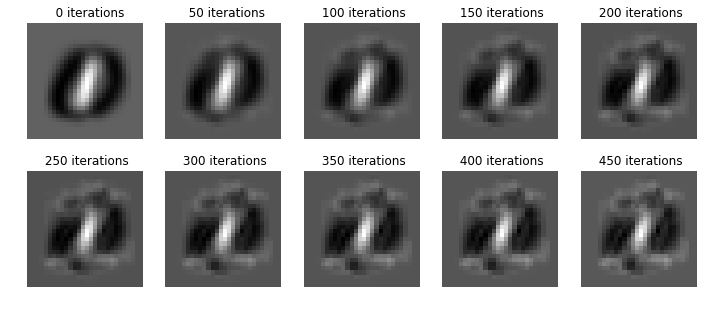

In [23]:
eta = 5e-5  # step size (learning rate)
num_steps = 500

# this block is for plot
fig, axes = plt.subplots(2,5, figsize=(12, 5))
axes = axes.reshape(-1)


loss_at_eachstep = np.zeros(num_steps) # record the change of the loss function
for i in range(num_steps):
    loss_at_eachstep[i] = loss(w,X,y)
    dw = gradient_loss(w,X,y)
    w = w - eta * dw
    if i % 50 == 0: # plot weights and print loss every 50 steps
        print("loss after", i+1, "iterations is: ", loss(w,X,y))
        axes[i//50].axis('off')
        axes[i//50].imshow(w.reshape(28,28), cmap = 'gray')
        axes[i//50].set_title("%4i iterations" % i)
        fig.canvas.draw()
        fig.canvas.flush_events()
        

In [27]:
w.shape

(784,)

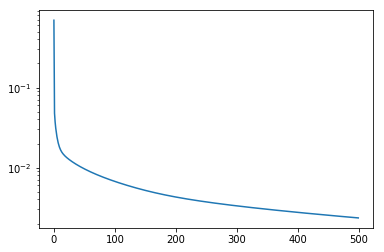

In [31]:
plt.plot(range(num_steps), loss_at_eachstep)
plt.yscale('log')
plt.show()

# Cross-validation (Judgement day)
Now let us use the testing data set to see if the the accuracy is good.

In [32]:
# import the testing data and extract zeros and ones like we did before
data_test = np.loadtxt('mnist_test.csv', delimiter=',')
X_test_total = data_test[:,1:]
y_test_total = data_test[:,0]
zero_and_one = (y_test_total == 1) + (y_test_total == 0) 
zero_and_one_indx = np.nonzero(zero_and_one)
zero_and_one_indx = zero_and_one_indx[0]
X_test = X_test_total[zero_and_one_indx,:]
y_test = y_test_total[zero_and_one_indx].astype(int) # we want our label to be an integer

In [33]:
# compute the y_pred using the weights w and X_test
sigmoid_based_on_w = h(w,X_test)
y_pred = 1*(sigmoid_based_on_w > 0.5) # integer
# if sigmnoid is > 0.5, it is the 2nd class (one), otherwise it is the first class (zero)
percentage_getting_label_correct = np.mean(y_pred == y_test)
print("{:.5%}".format(percentage_getting_label_correct))

99.90544%


In [34]:
y_test.shape

(2115,)

In [35]:
h(w,X_test).shape

(2115,)

In [36]:
1.0*(h(w,X_test) > 0.5)[:10]

array([1., 0., 1., 0., 0., 1., 0., 0., 1., 1.])

In [37]:
# accuracy
np.mean(y_pred == y_test)

0.9990543735224586

## In-class exercise:
Read the manual of the [logistic regression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) in `scikit-learn`, follow the example there to redo the classification above.

In [38]:
from sklearn.linear_model import LogisticRegression

In [41]:
mnist_binary_reg = LogisticRegression(solver= 'lbfgs',max_iter=1000, verbose=True)

In [43]:
mnist_binary_reg.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=True, warm_start=False)

In [45]:
y_pred = mnist_binary_reg.predict(X_test)
percentage_getting_label_correct = np.mean(y_pred == y_test)
print("{:.5%}".format(percentage_getting_label_correct))

99.90544%


In [46]:
# or you can use score function
mnist_binary_reg.score(X_test,y_test)

0.9990543735224586